In [1]:
import dgl
import numpy as np
import torch
import networkx as nx
import random
import math

Using backend: pytorch
/home/vijay/anaconda3/envs/ece517/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


In [162]:
def genRandomGraph(
    seed=None,
    num_edges=None,
    num_nodes=None,
    graph_type=None,
    ignore_circular=True
):  
    if seed != None:
        random.seed(seed)
        dgl.seed(seed)

    '''
    if graph_type == None:
        _types = [None, 'star', 'cyclic', 'lollipop']
        graph_type = np.random.choice(_types)
    '''

    print('graph_type: %s'%graph_type)
        
    if num_edges == None or num_nodes == None:
        while ignore_circular:
            # initializations if parameters are None:
            if num_edges == None:
                lower_end_edges = 30
                num_edges = random.randint(lower_end_edges,50)

            if num_nodes == None:
                lower_end_nodes = 20
                num_nodes = random.randint(lower_end_nodes,50)
                
            if num_edges - num_nodes != 0:
                break

    print('num_nodes: %i\nnum_edges: %i'%(num_nodes, num_edges))

    # Generate graph:
    if graph_type == None:
        #return dgl.rand_graph(num_nodes, num_edges)
        _g = dgl.to_homogeneous(dgl.rand_graph(num_nodes, num_edges))
        g =  dgl.add_reverse_edges(dgl.transform.remove_self_loop(_g))
        #g = dgl.transform.remove_self_loop(_g)
        fixMissingConnections(g)
        return g
    elif graph_type == 'star':
        if num_edges != None:
            print('NOTE: not using num_edges because type set to star')
        G = nx.generators.classic.star_graph(num_nodes)
        return dgl.from_networkx(G)
    elif graph_type == 'cyclic':
        if num_edges != None:
            print('NOTE: not using num_edges because type set to cyclic')
        G = nx.generators.classic.cycle_graph(num_nodes)
        return dgl.from_networkx(G)
    elif graph_type == 'lollipop':
        if num_edges != None:
            print('NOTE: not using num_edges because type set to lollipop')
        tail_length = random.randint(1,20)
        print('tail_length: %i'%tail_length)
        G = nx.generators.classic.lollipop_graph(num_nodes, tail_length)
        return dgl.from_networkx(G)
    elif graph_type == 'fully':
        # fully connected
        pass
    else:
        raise Exception('Unsupported entry assigned to graph_type parameter')
    return -1

In [101]:
def vizGraph(G):
    nx_G = G.to_networkx().to_undirected()
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

graph_type: None
num_nodes: 20
num_edges: 30
[{tensor(10), tensor(10), tensor(5), tensor(17), tensor(4), tensor(6), tensor(6), tensor(0), tensor(13), tensor(12), tensor(14), tensor(6), tensor(15), tensor(6), tensor(9), tensor(15), tensor(16), tensor(17), tensor(12), tensor(13), tensor(17), tensor(2), tensor(15), tensor(1), tensor(5), tensor(11), tensor(10), tensor(16), tensor(3), tensor(6), tensor(19), tensor(8), tensor(1), tensor(12), tensor(5), tensor(15), tensor(18), tensor(1), tensor(2), tensor(16), tensor(17), tensor(14), tensor(16), tensor(0), tensor(9), tensor(12), tensor(16), tensor(10), tensor(6), tensor(0), tensor(1), tensor(12), tensor(14), tensor(0), tensor(5), tensor(17), tensor(12), tensor(5)}, {tensor(11), tensor(14), tensor(10), tensor(17), tensor(1), tensor(6), tensor(16), tensor(10), tensor(1), tensor(10), tensor(6), tensor(6), tensor(13), tensor(1), tensor(5), tensor(2), tensor(12), tensor(15), tensor(2), tensor(17), tensor(14), tensor(12), tensor(12), tensor(6), ten

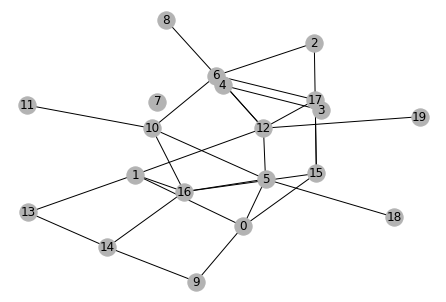

In [102]:
test = genRandomGraph(graph_type=None, num_nodes=20, num_edges=30)
print(test) 
vizGraph(test)

In [185]:
def fixMissingConnections(g):
    isolated = list(nx.isolates(g))
    print(isolated)
    
    # fix the obvious isolated nodes:
    if len(isolated):
        acceptable_node = 0
        while not acceptable_node in isolated:
            acceptable_node += 1

        # join together:
        for iso in isolated:
            g.add_edge(acceptable_node, iso)
    
    # create reachability matrix:    
    length = dict(nx.all_pairs_shortest_path_length(g))
    R = np.array([[length.get(m, {}).get(n, 0) > 0 for m in g.nodes] for n in g.nodes], dtype=np.int32)
    
    # find largest chain of reachable nodes to reference:
    print(R)
    _sum = R.sum(axis=1)
    print(_sum)
    print(R[0][1:])
    print([r for r in range(len(R[0][1:])) if not R[0][r]])

# using only networkx
def genRandomGraphX(num_nodes, num_edges):
    # Generate random complete graph:
    _g = dgl.to_homogeneous(dgl.rand_graph(num_nodes, num_edges))
    G = dgl.transform.remove_self_loop(_g)
    #G = nx.fast_gnp_random_graph(num_nodes,0.25)
    nx_G = G.to_networkx().to_undirected()
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
    return nx_G

[12]
[[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]]
[18 18 18 18 18 18 18 18 18 18 18 18  0 18 18 18 18 18 18 18]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
[0, 12]


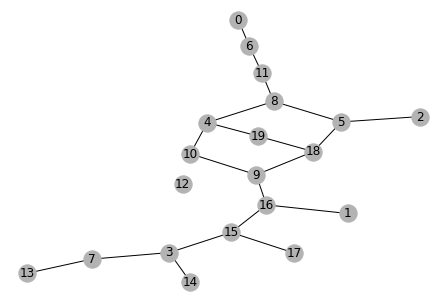

In [182]:
g = genRandomGraphX(20,20)
fixMissingConnections(g)

In [183]:
gg = g

In [187]:
fixMissingConnections(gg)
gg.edges(12)

[]
[[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]]
[18 18 18 18 18 18 18 18 18 18 18 18  0 18 18 18 18 18 18 18]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
[0, 12]


MultiEdgeDataView([(12, 12)])

In [192]:
# attempt 3: generate a cyclic graph and randomize the rest of the edges (n-node, n-edges, + extra edges for randomness)

def genRandomGraphX2(num_nodes, num_edges):
    G = nx.cycle_graph(num_nodes)
    
    # random edges:
    edges_added = 0
    while edges_added < num_edges-num_nodes:
        u,v = random.randint(0,num_nodes), random.randint(0,num_nodes)
        if not G.has_edge(u,v):
            G.add_edge(u,v)
            edges_added += 1
    
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=[[.7, .7, .7]])
    return G

30

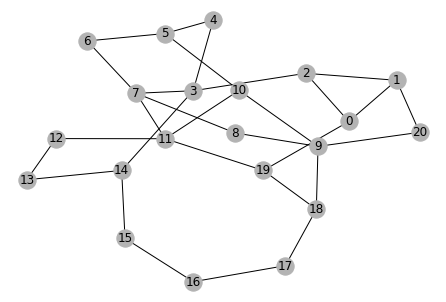

In [224]:
G = genRandomGraphX2(20,30)
len(G.edges())

In [211]:
def efficiencyMetric(G):
    floyd = nx.floyd_warshall_numpy(G)
    _mean = np.mean(floyd)
    assert _mean != np.inf
    return _mean

In [225]:
efficiencyMetric(G)

2.6575963718820863